## Mortgage Loans: Linear Regression Example

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv('../data/ames_housing.csv')
df.shape

(1460, 81)

In [4]:
features = ['YearBuilt','Bathrooms','BedroomAbvGr','TotalSF','SingleFam','LargeNeighborhood']

In [5]:
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


## Exploratory data analysis

In [6]:
# target
print(df['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [7]:
# remove extreme outliers
print(df.shape[0])
cutpoint = df['SalePrice'].mean()+3* df['SalePrice'].std()
print(cutpoint)
df=df[df['SalePrice']<=cutpoint].copy()
print(df.shape[0])

1460
419248.70453907084
1438


In [8]:
# recoding neighborhood
print(df['Neighborhood'].value_counts().head())
df['Location']='Other'
df.loc[df['Neighborhood']=='NAmes', 'Location']='NAmes'
df.loc[df['Neighborhood']=='CollgCr', 'Location']='CollgCr'
df.loc[df['Neighborhood']=='OldTown', 'Location']='OldTown'
df.loc[df['Neighborhood']=='Somerst', 'Location']='Somerst'
df['Location'].value_counts()

NAmes      225
CollgCr    149
OldTown    112
Edwards    100
Somerst     85
Name: Neighborhood, dtype: int64


Other      867
NAmes      225
CollgCr    149
OldTown    112
Somerst     85
Name: Location, dtype: int64

In [9]:
# make neighborhood binary for simplicity
df['LargeNeighborhood']=np.where(df['Location']=='Other', 0,1)

In [10]:
# recoding building type
print(df['BldgType'].value_counts())
df['SingleFam']=np.where(df['BldgType']=='1Fam',1,0)
print(df['SingleFam'].value_counts())

1Fam      1198
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64
1    1198
0     240
Name: SingleFam, dtype: int64


In [11]:
# recoding total square feet
df['TotalSF'] = df['TotalBsmtSF']+df['1stFlrSF']+df['2ndFlrSF']
df['TotalSF'].describe()

count     1438.000000
mean      2532.068150
std        769.994523
min        334.000000
25%       2004.250000
50%       2460.000000
75%       2982.500000
max      11752.000000
Name: TotalSF, dtype: float64

In [12]:
# bedrooms
df['BedroomAbvGr'].describe()

count    1438.000000
mean        2.863004
std         0.811372
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64

In [13]:
# recoding bathrooms
df['Bathrooms']=df['FullBath']+df['HalfBath']
df['Bathrooms'].describe()

count    1438.000000
mean        1.929068
std         0.781112
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: Bathrooms, dtype: float64

In [14]:
# year
df['YearBuilt'].describe()

count    1438.000000
mean     1970.844924
std        30.093041
min      1872.000000
25%      1953.250000
50%      1972.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

In [80]:
df['OverallCond'].value_counts()

5    801
6    251
7    205
8     72
4     57
3     25
9     21
2      5
1      1
Name: OverallCond, dtype: int64

In [15]:
df['OverallCond'].value_counts()/df['OverallCond'].count()

5    0.557024
6    0.174548
7    0.142559
8    0.050070
4    0.039638
3    0.017385
9    0.014604
2    0.003477
1    0.000695
Name: OverallCond, dtype: float64

In [16]:
df['SaleCondition'].value_counts()/df['SaleCondition'].count()

Normal     0.827538
Partial    0.077886
Abnorml    0.069541
Family     0.013908
Alloca     0.008345
AdjLand    0.002782
Name: SaleCondition, dtype: float64

In [17]:
df['SaleCondition_new']=np.where(df['SaleCondition']=='Normal', 1,0)

In [79]:
# confirm no missing data
df[['SalePrice','YearBuilt','Bathrooms','BedroomAbvGr','TotalSF','SingleFam','LargeNeighborhood','SaleCondition_new','OverallCond']].isnull().sum()

SalePrice            0
YearBuilt            0
Bathrooms            0
BedroomAbvGr         0
TotalSF              0
SingleFam            0
LargeNeighborhood    0
SaleCondition_new    0
OverallCond          0
dtype: int64

In [19]:
# confirm all numerical
df[['SalePrice','YearBuilt','Bathrooms','BedroomAbvGr','TotalSF','SingleFam','LargeNeighborhood','SaleCondition_new']].dtypes

SalePrice            int64
YearBuilt            int64
Bathrooms            int64
BedroomAbvGr         int64
TotalSF              int64
SingleFam            int64
LargeNeighborhood    int64
SaleCondition_new    int64
dtype: object

## Model Building

In [55]:
# declare features and target
features = ['YearBuilt','Bathrooms','BedroomAbvGr','TotalSF','SingleFam','LargeNeighborhood','OverallCond']
y = df['SalePrice']
X = df[features]
print(y.shape, X.shape)

(1438,) (1438, 7)


In [56]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=12)

In [57]:
# Fit the model to the training dataset
mymodel = LinearRegression()
mymodel.fit(X_train, y_train)

LinearRegression()

In [58]:
# coefficients and intercept
print(mymodel.intercept_)
print(mymodel.coef_)

-1613888.8052933023
[  807.3600877  12525.2540791  -7190.30486189    50.38142415
 20970.94666193 -6803.15676359  9256.31545804]


In [59]:
# what is the equation for this model?
cols=list(X.columns)
coefs=list(mymodel.coef_)
xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]
equation = f'y = {round(mymodel.intercept_,4)} + {round(xcoefs[0][0],4)}*{xcoefs[0][1]} + {round(xcoefs[1][0],4)}*{xcoefs[1][1]} + {round(xcoefs[2][0],4)}*{xcoefs[2][1]} + {round(xcoefs[3][0],4)}*{xcoefs[3][1]}+ {round(xcoefs[4][0],4)}*{xcoefs[4][1]}+ {round(xcoefs[5][0],4)}*{xcoefs[5][1]}+ {round(xcoefs[6][0],4)}*{xcoefs[6][1]} '
print("Regression Equation: ", equation)  

Regression Equation:  y = -1613888.8053 + 807.3601*YearBuilt + 12525.2541*Bathrooms + -7190.3049*BedroomAbvGr + 50.3814*TotalSF+ 20970.9467*SingleFam+ -6803.1568*LargeNeighborhood+ 9256.3155*OverallCond 


In [60]:
# Predict the y-values on the testing dataset & examine the first few
y_preds = [int(x) for x in mymodel.predict(X_test)]
print(list(y_test[:6]))
print(y_preds[:6])

[132000, 160000, 149700, 82000, 233170, 224900]
[103247, 127859, 151440, 79491, 230175, 229908]


## Model Evaluation

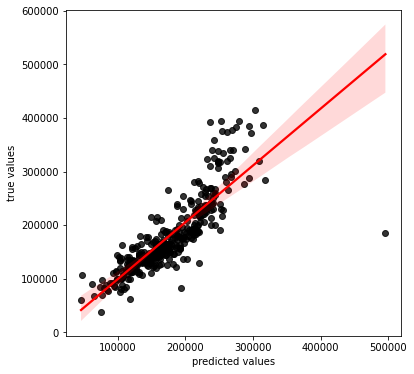

In [61]:
# compare predictions to known values
plt.figure(figsize=(6,6))
ax = sns.regplot(x = y_preds, 
                 y = y_test, 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"})
ax.set(xlabel='predicted values', ylabel='true values');

In [62]:
# R-2 (coefficient of determination)
r2 = metrics.r2_score(y_test, y_preds)
round(r2, 2)

0.7

In [63]:
# root mean sq error
rmse = sqrt(metrics.mean_squared_error(y_test, y_preds))
rmse

39033.36035524257

In [64]:
# is that more or less than if we just used the average as our model?
avg_val = y_train.mean()
comparison = np.full((len(y_test), ), avg_val)
baseline=sqrt(metrics.mean_squared_error(y_test, comparison))
print(round(baseline,2))
print(round(rmse,2))
print('improvement:',round(rmse-baseline,2))

71241.69
39033.36
improvement: -32208.33


## Make new predictions

In [65]:
# remember the linear regression equation?
print(equation)

y = -1613888.8053 + 807.3601*YearBuilt + 12525.2541*Bathrooms + -7190.3049*BedroomAbvGr + 50.3814*TotalSF+ 20970.9467*SingleFam+ -6803.1568*LargeNeighborhood+ 9256.3155*OverallCond 


In [66]:
# make some fake data
fake1= [[2010, 2, 3, 2000, 1,0,1]] # modest SF home
fake2= [[2015, 3, 5, 4000, 1,1,0]] # large SF home in big neighborhood
fake3= [[1980, 1, 2, 1000, 0,0,1]] # small home, not SF, outside big neighborhood

In [74]:
# make predictions just using our equation:
for data in [fake1, fake2, fake3]:
    YearBuilt=data[0][0]
    Bathrooms=data[0][1]
    BedroomAbvGr=data[0][2]
    TotalSF=data[0][3]
    SingleFam=data[0][4]
    LargeNeighborhood=data[0][5]
    OverallCond = data[0][6]
    y = -1613888.8053 + 807.3601*YearBuilt + 12525.2541*Bathrooms + -7190.3049*BedroomAbvGr + 50.3814*TotalSF+ 20970.9467*SingleFam+ -6803.1568*LargeNeighborhood+ 9256.3155*OverallCond  
    print('$',int(y))

$ 143374
$ 230259
$ 42466


In [75]:
# pickle your model
import pickle
filename = open('ames_housing_lr_model.pkl', 'wb')
pickle.dump(mymodel, filename)
filename.close()

In [76]:
## read in our pickle file
filename = open('ames_housing_lr_model.pkl', 'rb')
unpickled_model = pickle.load(filename)
filename.close()

In [77]:
# make predictions
for data in [fake1, fake2, fake3]:
    print('$',int(unpickled_model.predict(data)))

$ 143374
$ 230259
$ 42466


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Turn that into a function

In [82]:
def ames_lr_function(YearBuilt,Bathrooms,BedroomAbvGr,TotalSF,SingleFam,LargeNeighborhood,OverallCond):
    checksum=0
    for var in [YearBuilt,Bathrooms,BedroomAbvGr,TotalSF,SingleFam,LargeNeighborhood,OverallCond]:
        if isinstance(var,int)==False:
            checksum+=1
    if (YearBuilt<1900)|(YearBuilt>2020):
        checksum+=1
    if (Bathrooms<1) | (Bathrooms>5):
        checksum+=1
    if (BedroomAbvGr<1) | (BedroomAbvGr>5):
        checksum+=1
    if (TotalSF<100)|(TotalSF>5000):
        checksum+=1
    if (SingleFam!=0) & (SingleFam!=1):
        checksum+=1
    if (LargeNeighborhood!=0) & (LargeNeighborhood!=1):
        checksum+=1
    if (OverallCond<=1) & (OverallCond>=10):
        checksum+=1  
    if checksum>0:
        return "Please provide adequate inputs"
    else:
        # y = [-1360501.3809 + 704.4287*YearBuilt + 12738.4775*Bathrooms + -7783.1712*BedroomAbvGr + 49.824*TotalSF+ 25282.091*SingleFam+ -6637.2636*LargeNeighborhood]
#         y = unpickled_model.predict([[YearBuilt,Bathrooms,BedroomAbvGr,TotalSF,SingleFam,LargeNeighborhood]])
          y = [-1381877.7121 + 713.5426*YearBuilt + 12533.8927*Bathrooms + -7796.0143*BedroomAbvGr + 50.0015*TotalSF+ 25232.7346*SingleFam+ -6662.2806*LargeNeighborhood+ 4172.6642*OverallCond]   
    
    formatted_y = "${:,.2f}".format(y[0])
    return formatted_y 

In [83]:
# test the function
YearBuilt=2015
Bathrooms=3
BedroomAbvGr=3
TotalSF=2000
SingleFam=0
LargeNeighborhood=1
OverallCond = 1

ames_lr_function(YearBuilt,Bathrooms,BedroomAbvGr,TotalSF,SingleFam,LargeNeighborhood,OverallCond)

'$167,637.65'